In [2]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset

/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def crop_center(img):
    y, x = img.shape[0:2]  # Get the original dimensions of the image
    
    startx = x // 2 - 10
    starty = y // 2 - 10
    
    return img[starty:starty + 21, startx:startx + 21]

In [76]:

# Load the TXT file
labels_df = pd.read_csv('data/0ADD710_gated_full_final.txt', sep='\t')
print(labels_df.shape)

from collections import Counter

# Analyze class distribution
class_counts = Counter(labels_df['Binary_classification'])
print(f"Class distribution: {class_counts}")

# Randomly undersample the majority class to balance the dataset
majority_class = 'Myelocytes' if class_counts['Myelocytes'] > class_counts['Lymphocytes'] else 'Lymphocytes'
minority_class_count = class_counts['Lymphocytes' if majority_class == 'Myelocytes' else 'Myelocytes']

# Create a balanced DataFrame by sampling from the majority class
balanced_df = pd.concat([
    labels_df[labels_df['Binary_classification'] == majority_class].sample(minority_class_count, random_state=42),
    labels_df[labels_df['Binary_classification'] != majority_class]
]).sample(frac=1, random_state=42)  # Shuffle the dataset

# Map string labels to integers
labels_int = balanced_df['Binary_classification'].map({'Lymphocytes': 1, 'Myelocytes': 0}).values
print(labels_int.shape)

# Open the HDF5 file
with h5py.File('data/0ADD710_gated_full_final.hdf5', 'a') as hdf5_file:
    original_images = hdf5_file['images']
    
    # Correct the dataset size for cropped images
    new_shape = (len(balanced_df), 21, 21) + original_images.shape[3:]
    
    # Update or create 'filtered_images' dataset
    if 'cropped_images' in hdf5_file.keys():
        del hdf5_file['cropped_images']
    cropped_images = hdf5_file.create_dataset('cropped_images', shape=new_shape, dtype=original_images.dtype)
    
    # Use original indices to ensure correct image mapping
    for new_idx, (orig_idx, _) in enumerate(balanced_df.iterrows()):
        orig_img = original_images[orig_idx]
        cropped_img = crop_center(np.array(orig_img))
        cropped_images[new_idx] = cropped_img

    # Update or create 'targets' dataset with balanced labels
    if 'cropped_targets' in hdf5_file.keys():
        del hdf5_file['cropped_targets']
    hdf5_file.create_dataset('cropped_targets', data=labels_int)

print("All labels and cropped images appended to HDF5 file successfully.")


(29028, 93)
Class distribution: Counter({'Myelocytes': 19069, 'Lymphocytes': 9959})
(19918,)
All labels and cropped images appended to HDF5 file successfully.


In [79]:
# set parameters
torch.manual_seed(42)

file_path = 'data/0ADD710_gated_full_final.hdf5'
# file_path = '0B11619_10x.hdf5'
data_split = (0.7, 0.15, 0.15)
batch_size = 256
learning_rate = 0.003
weight_decay = 0.0005
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cpu


In [80]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        # Open the HDF5 file
        self.hdf5_file = h5py.File(file_path, 'r')

        # Get the number of samples in the dataset
        # self.num_samples = len(self.hdf5_file['images'])
        self.num_samples = len(self.hdf5_file['cropped_images'])

    def permute(self, image):
        if len(image.shape) == 3:
            return image.permute(2, 0, 1)
        else:
            return image.permute(0, 3, 1, 2)

    def __getitem__(self, index):
        # Get the image and target from the HDF5 file
        
        image = self.hdf5_file['cropped_images'][index, :, :, [0, 2]] / 65535.0
        # image = self.hdf5_file['images'][index, 12:33, 12:33, [0, 2]] / 65535.0
        target = self.hdf5_file['cropped_targets'][index]

        # Convert the image and target to PyTorch tensors
        image = self.permute(torch.from_numpy(image).float())
        target = torch.from_numpy(np.asarray(target)[..., np.newaxis]).float()

        # Apply any data augmentations or transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.num_samples

# Define your deep neural network model
class BinaryImageClassificationModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BinaryImageClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)

        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        x = self.sigmoid(x)

        return x

    

In [81]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs):
    all_train_loss = []
    all_train_accu = []
    all_val_loss = []
    all_val_accu = []
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accu = 0.0

        # Train the model on the training dataset
        for inputs, targets in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            train_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                          targets.cpu().detach().numpy())
            

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate the average training loss
        train_loss /= len(train_loader.dataset)
        train_accu /= len(train_loader.dataset)
        all_train_loss.append(train_loss)
        all_train_accu.append(train_accu)
        
        # Evaluate the model on the validation dataset
        model.eval()
        val_loss = 0.0
        val_accu = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move data to GPU if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                # Forward pass
                outputs = model(inputs)

                loss = criterion(outputs, targets)
                val_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                            targets.cpu().detach().numpy())
                val_loss += loss.item() * inputs.size(0)
        
        # Calculate the average validation loss
        # print(len(train_loader.dataset), len(val_loader.dataset))
        val_loss /= len(val_loader.dataset)
        val_accu /= len(val_loader.dataset)
        all_val_loss.append(val_loss)
        all_val_accu.append(val_accu)
        
        # Print the training and validation losses for this epoch
        print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}, Train Accu: {:.6f}, Val Accu: {:.6f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, train_accu, val_accu))
        
        # Step the scheduler on each epoch
        scheduler.step(val_loss)
    
    return all_train_loss, all_val_loss, all_train_accu, all_val_accu

def test(model, test_loader):
    model.eval()
    test_pred = np.empty((0,))
    test_target = np.empty((0,))
    test_images = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Forward pass and record predictions
            test_images.append(inputs.cpu().detach().numpy())
            outputs = model(inputs)
            test_pred = np.append(test_pred, outputs.cpu().detach().numpy())
            
            test_target = np.append(test_target, targets.cpu().detach().numpy())
    
    return test_pred, test_target, np.concatenate(test_images, axis=0)

def calc_accuracy(pred, target, threshold=0.5):
    pred = np.asarray(pred.copy())
    target = np.asarray(target.copy())
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    return np.sum(pred == target) / len(pred)

In [82]:
def calculate_mean_std(loader):
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for images, _ in loader:
        # Assuming images are in shape (batch_size, channels, height, width)
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Using the data loader to calculate mean and std
loader = DataLoader(HDF5Dataset(file_path), batch_size=10, shuffle=False)
mean_values, std_values = calculate_mean_std(loader)
print(f"Calculated mean: {mean_values}")
print(f"Calculated std: {std_values}")

rotation_range = (-85, 85)  # Desired rotation angles

# Define transformations for the training data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(rotation_range),  # Rotation with a range
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=mean_values, std=std_values)  # Normalize images
])

# Transformations for the validation and test sets should not contain any augmentation.
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

Calculated mean: tensor([0.0496, 0.0640])
Calculated std: tensor([0.0927, 0.0890])


In [83]:
# Setup the training phase
model = BinaryImageClassificationModel(dropout_rate=0.3)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.3, verbose=True)

# Creating dataset instances with specific transformations
train_dataset = HDF5Dataset(file_path, transform=train_transforms)
val_dataset = HDF5Dataset(file_path, transform=test_transforms)
test_dataset = HDF5Dataset(file_path, transform=test_transforms)

# Determine sizes for each dataset split
dataset_size = len(train_dataset)  # train_dataset could be used to measure dataset size before splitting 
train_size = int(data_split[0] * dataset_size)
val_size = int(data_split[1] * dataset_size)
test_size = dataset_size - train_size - val_size

# Generate indices and split them
indices = torch.randperm(dataset_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create data subsets for each split
train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)
test_set = Subset(test_dataset, test_indices)


# Create DataLoader objects for each dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=test_size, shuffle=False)

In [84]:
train_loss, val_loss, train_accu, val_accu = train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs)

Epoch [1/120], Train Loss: 0.497343, Val Loss: 0.408211, Train Accu: 0.778296, Val Accu: 0.837630
Epoch [2/120], Train Loss: 0.391628, Val Loss: 0.365091, Train Accu: 0.854253, Val Accu: 0.871778
Epoch [3/120], Train Loss: 0.370796, Val Loss: 0.358907, Train Accu: 0.865299, Val Accu: 0.855039
Epoch [4/120], Train Loss: 0.367803, Val Loss: 0.356095, Train Accu: 0.867164, Val Accu: 0.874456
Epoch [5/120], Train Loss: 0.366612, Val Loss: 0.358579, Train Accu: 0.868670, Val Accu: 0.874456
Epoch [6/120], Train Loss: 0.357834, Val Loss: 0.390942, Train Accu: 0.870607, Val Accu: 0.851691
Epoch [7/120], Train Loss: 0.363058, Val Loss: 0.383304, Train Accu: 0.868240, Val Accu: 0.844995
Epoch [8/120], Train Loss: 0.354392, Val Loss: 0.371814, Train Accu: 0.874839, Val Accu: 0.856378
Epoch [9/120], Train Loss: 0.355266, Val Loss: 0.347981, Train Accu: 0.872472, Val Accu: 0.869769
Epoch [10/120], Train Loss: 0.349518, Val Loss: 0.467586, Train Accu: 0.874982, Val Accu: 0.799130
Epoch [11/120], Tra

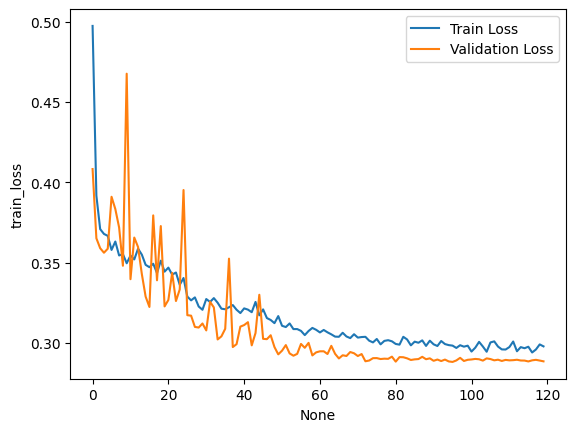

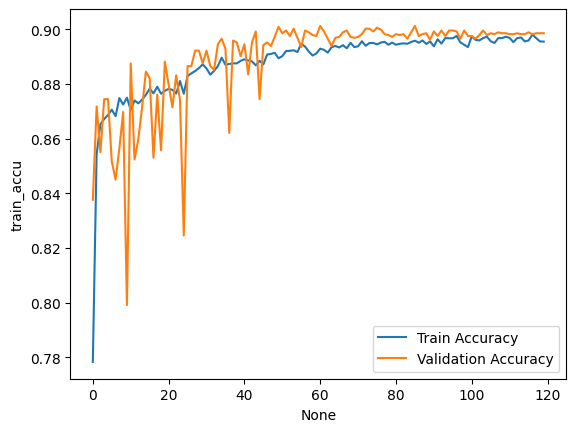

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot the training and validation losses
train_perf = pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss})
sns.lineplot(data=train_perf, y='train_loss', x=train_perf.index, label='Train Loss')
sns.lineplot(data=train_perf, y='val_loss', x=train_perf.index, label='Validation Loss')
plt.show()

# Plot the training and validation accuracies
plt.figure()
train_perf = pd.DataFrame({'train_accu': train_accu, 'val_accu': val_accu})
sns.lineplot(data=train_perf, y='train_accu', x=train_perf.index, label='Train Accuracy')
sns.lineplot(data=train_perf, y='val_accu', x=train_perf.index, label='Validation Accuracy')
plt.show()

Test Accuracy: 0.9016393442622951


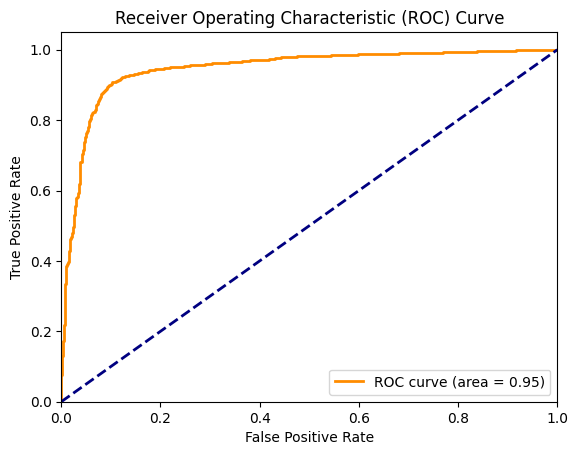

In [86]:
# predict on test set
test_pred, test_target, test_image = test(model, test_loader)
print(f"Test Accuracy: {calc_accuracy(test_pred, test_target)}")

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_target, test_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

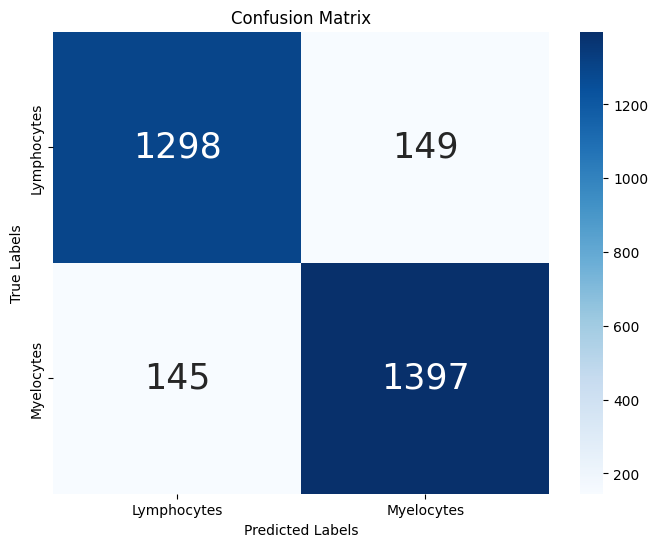

Mismatch rate: 9.84%


In [87]:
from sklearn.metrics import confusion_matrix

pred_labels = (test_pred >= 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold

# Calculate the confusion matrix
cm = confusion_matrix(test_target, pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 25}, xticklabels=['Lymphocytes', 'Myelocytes'], yticklabels=['Lymphocytes', 'Myelocytes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the mismatch rate
total_instances = cm.sum()
correct_predictions = np.trace(cm)
mismatch_rate = (total_instances - correct_predictions) / total_instances
print(f"Mismatch rate: {mismatch_rate:.2%}")


In [88]:
import random

def visualize_image_gallery(images, rows, cols):
    
    if len(images) < rows * cols:
        empty_images = np.repeat(np.zeros_like(images[0])[np.newaxis,...], len(images - rows * cols), axis=0)
        images = np.concatenate((images, empty_images), axis=0)
        
    elif len(images) > rows * cols:
        images = images[random.sample(range(len(images)), rows * cols)]

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=1, hspace=1)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

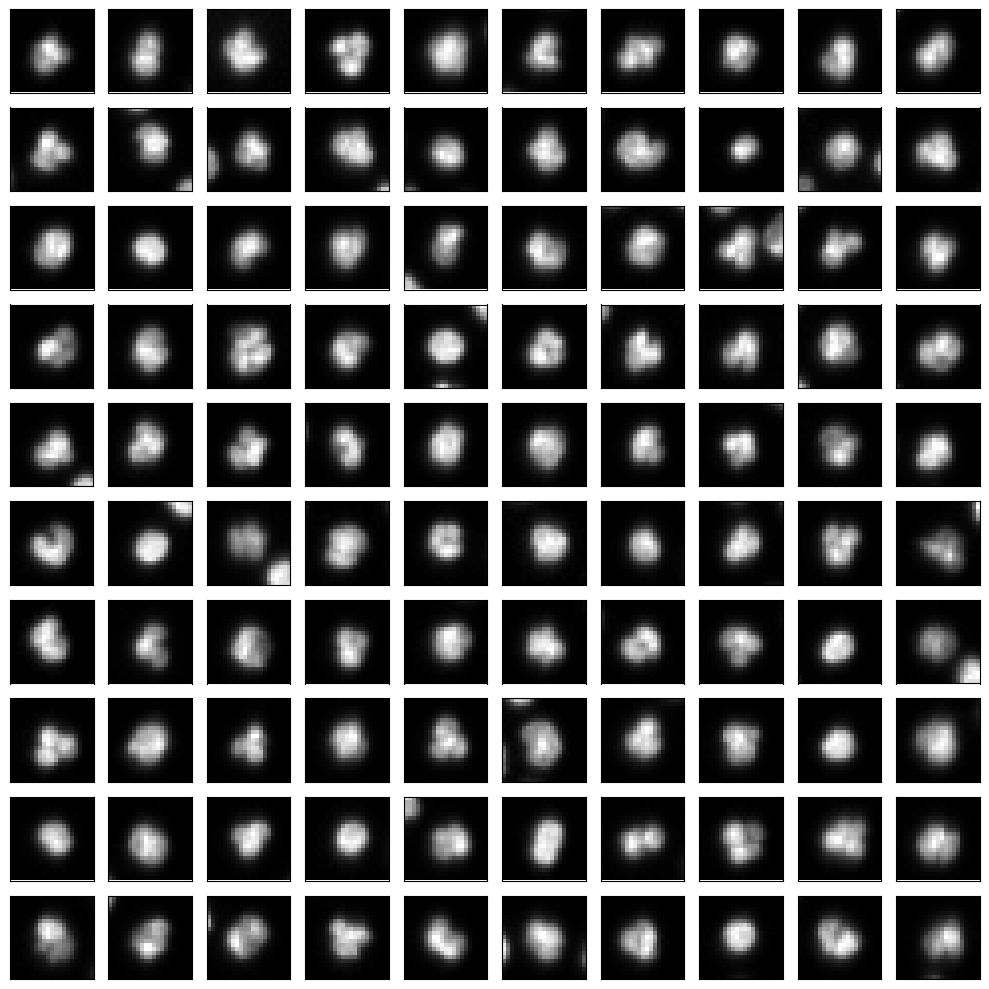

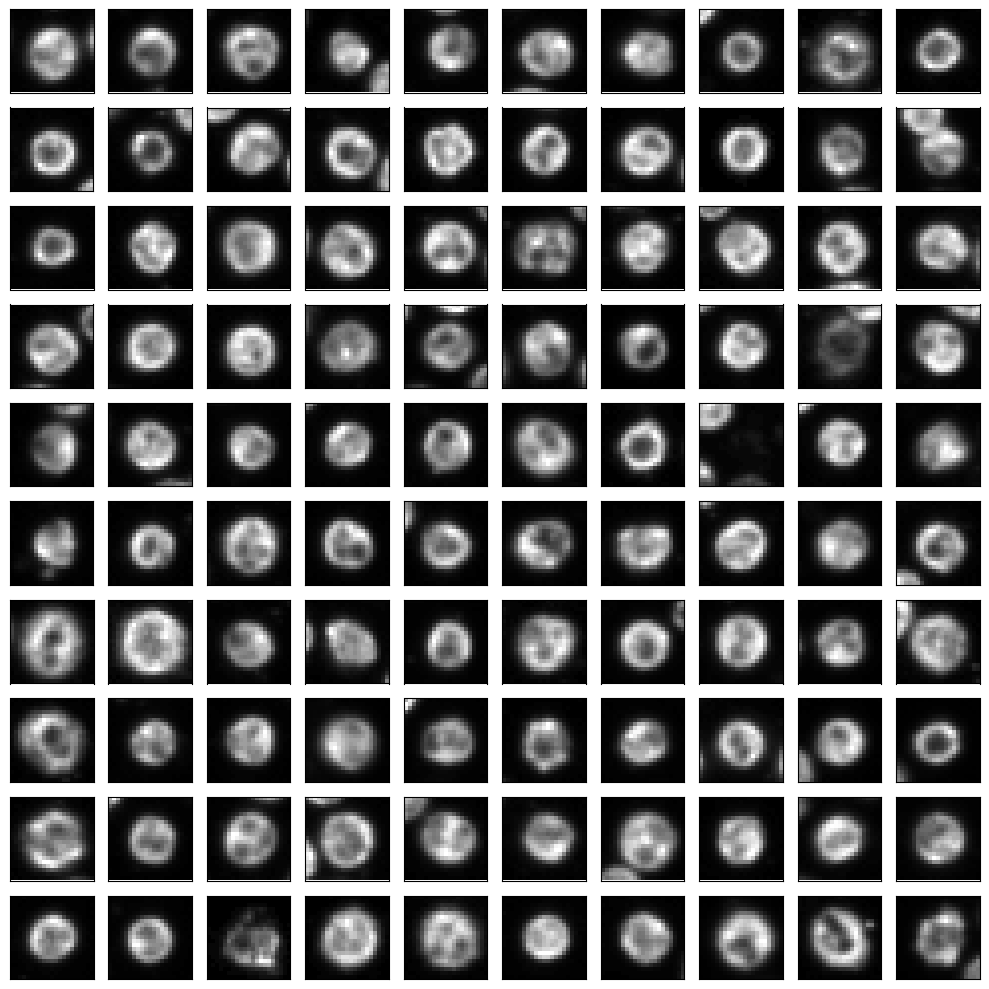

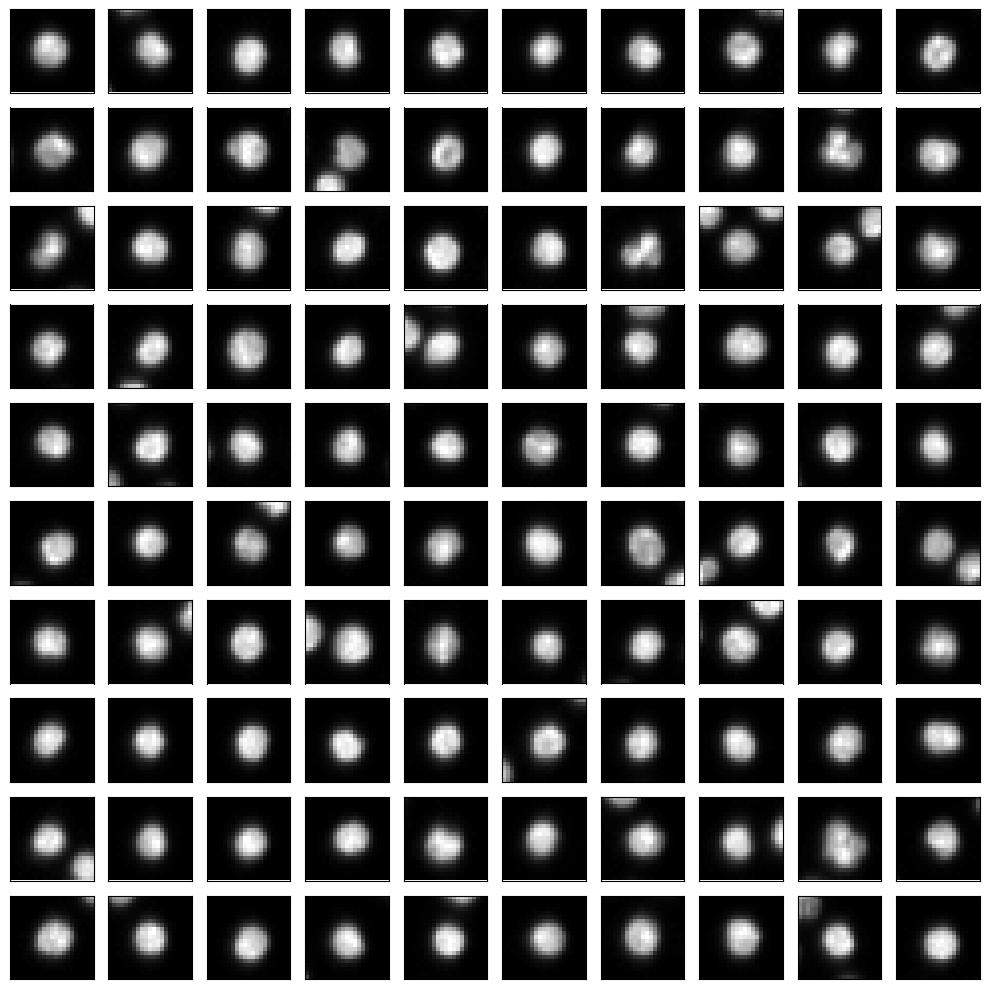

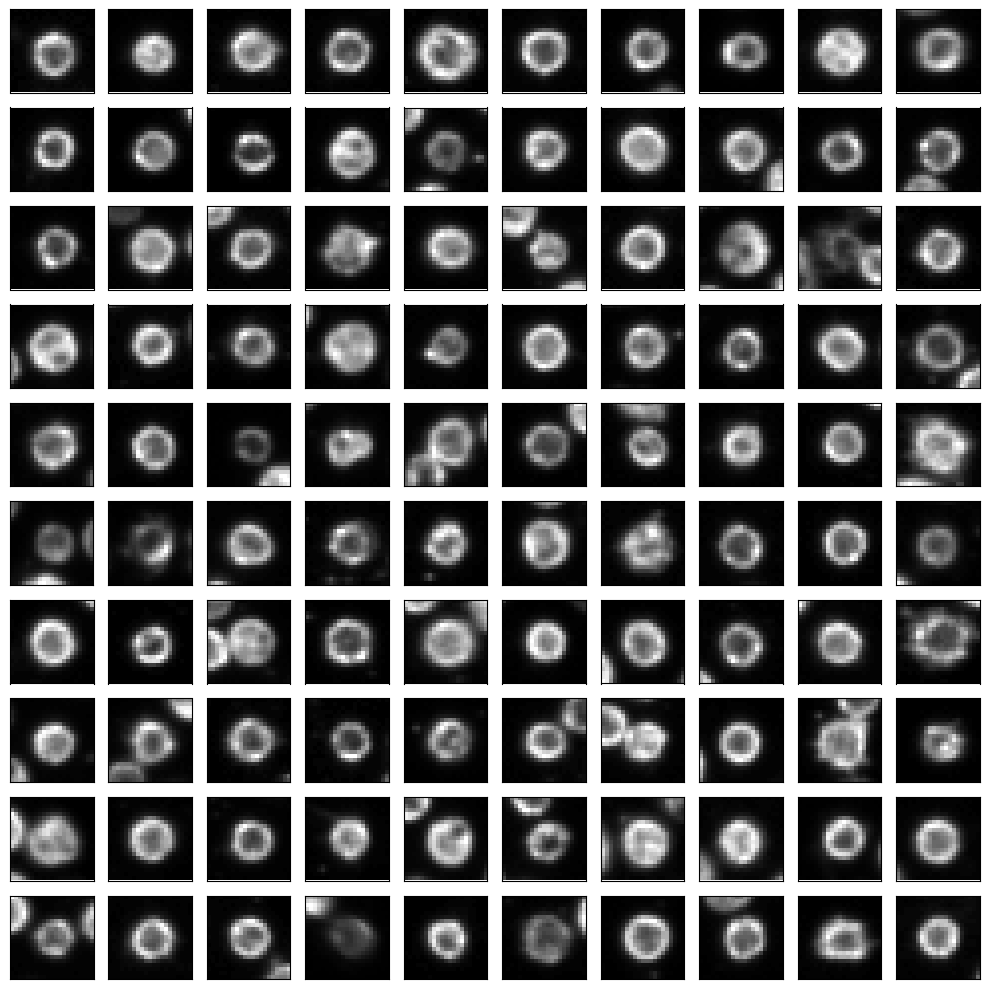

In [89]:
# Visualize the first 25 images in the test set
# lymph_index = np.where(test_target == 1)[0]
# visualize_image_gallery(test_image[lymph_index, 0, :, :], 10, 10)
# visualize_image_gallery(test_image[lymph_index, 1, :, :], 10, 10)

myeloid_index = np.where(test_target == 0)[0]
visualize_image_gallery(test_image[myeloid_index, 0, :, :], 10, 10)
visualize_image_gallery(test_image[myeloid_index, 1, :, :], 10, 10)

lymphoid_index = np.where(test_target == 1)[0]
visualize_image_gallery(test_image[lymphoid_index, 0, :, :], 10, 10)
visualize_image_gallery(test_image[lymphoid_index, 1, :, :], 10, 10)

In [90]:
torch.save(model.state_dict(), '0ADD710_binary_classification_model.pth')

In [91]:
# comments
# class HDF5Dataset(Dataset):
#     def __init__(self, file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform
        
#         # Open the HDF5 file
#         with h5py.File(file_path, 'r') as file:
#             self.images = file['images'][:]
            
#         self.images = self.images[:, 1:, 1:, :] / 65535.0
#         self.targets = pd.read_hdf(file_path, key='features',
#                                    mode='r')['target'].values

#         # Get the number of samples in the dataset
#         self.num_samples = len(self.targets)

#     def __getitem__(self, index):
#         # Get the image and target from the HDF5 file
#         image = self.images[index]
#         target = self.targets[index]

#         # Convert the image and target to PyTorch tensors
#         image = torch.from_numpy(image).float()
#         target = torch.from_numpy(target).float()

#         # Apply any data augmentations or transformations
#         if self.transform is not None:
#             image = self.transform(image)

#         return image, target

#     def __len__(self):
#         return self.num_samples